In [1]:
!pip install netcdf4 zarr dask-ml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 9.5 MB/s eta 0:00:00


In [2]:
import gcsfs


from __future__ import annotations

import pickle
import shutil

import numpy as np
import xarray as xr
import zipfile
from pandas import to_datetime

# TYPES
from argparse import ArgumentParser
from typing import Any, TYPE_CHECKING

from numpy import ndarray
from xarray import DataArray, Dataset

## Functions

In [3]:
def subset_region(
        ds: xr.Dataset,
        lon_min: float,
        lon_max: float,
        lat_min: float,
        lat_max: float,
    ) -> xr.Dataset:
    lat_slice = slice(max(lat_min, lat_max), min(lat_min, lat_max))

    if lon_min <= lon_max:
        return ds.sel({"lon": slice(lon_min, lon_max),
                       "lat": lat_slice})
    else:
        part1 = ds.sel({"lon": slice(lon_min, 360),
                        "lat": lat_slice})
        part2 = ds.sel({"lon": slice(0, lon_max),
                        "lat": lat_slice})
        return xr.concat([part1, part2], dim="lon")

def get_num_time_steps(ds: xr.Dataset, mb: int = 500) -> int:
    time_dime = "time"

    # Calculate number of elements for given MB size
    BYTES_PER_MB = 1024**2
    target_bytes = mb * BYTES_PER_MB
    itemsize = ds.dtype.itemsize
    chunk_elems = target_bytes // itemsize

    # Calculate required number of time steps for (roughly) MB size
    one_step_size = 1
    for coord, size in ds.coords.sizes.items():
        if (
            coord != time_dime
            and coord in ds.dims
        ):
            one_step_size *= size

    return round(chunk_elems / one_step_size)

def get_optimal_chunks_ds(ds: xr.Dataset) -> xr.Dataset:
    chunk_time_steps = get_num_time_steps(ds)

    chunk_dict = {
        coord: chunk_time_steps if coord == "time" else -1
        for coord in ds.dims
    }
    return ds.chunk(chunk_dict)


def reduce_mask(land_sea_mask: ndarray, patch_size: int) -> ndarray:
    n_lat_patches = land_sea_mask.shape[0] // patch_size
    n_lon_patches = land_sea_mask.shape[1] // patch_size
    land_sea_mask_patched = np.zeros((n_lat_patches, n_lon_patches), dtype=np.int8)
    for i in range(n_lat_patches):
        for j in range(n_lon_patches):
            lat_slice = slice(i * patch_size, (i+1) * patch_size)
            lon_slice = slice(j * patch_size, (j+1) * patch_size)
            patch_data = land_sea_mask[lat_slice, lon_slice]

            mean_val = np.mean(patch_data)
            if mean_val >= 0.5:
                land_sea_mask_patched[i, j] = 1
            else:
                land_sea_mask_patched[i, j] = 0

    return land_sea_mask_patched

def reduce_mask_lazy(mask: xr.DataArray, patch_size: int) -> DataArray:
    coarsened = mask.coarsen(latitude=patch_size, longitude=patch_size, boundary='trim')
    reduced = (coarsened.mean() >= 0.5).astype(np.int8)
    return reduced


# Analysis

In [4]:
# Read data from Google bucket
fs = gcsfs.GCSFileSystem(token='anon')
complete_dataset = 'gs://aurora-encoder-storage/encoder_embeddings_20240713_20241821.zarr'
store = fs.get_mapper(complete_dataset)
aurora_embeddings = xr.open_zarr(store, consolidated=True)

# Static data
store = fs.get_mapper('gs://aurora-encoder-storage/static.zarr')
static_data = xr.open_zarr(store, consolidated=True)

In [5]:
# Select surface and atmos embeddings
chunk_bytes = 500

surface_embeddings = get_optimal_chunks_ds(aurora_embeddings["surface_latent"])
atmos_embeddings = get_optimal_chunks_ds(aurora_embeddings["atmos_latent"])

In [6]:
# Other global variables
patch_size = 4

In [7]:
# Europe
lon_min, lon_max = 335, 45
lat_min, lat_max = 34, 72

surface_embed_europe = subset_region(surface_embeddings, lon_min=335, lon_max=45, lat_min=34, lat_max=72)


## Land-Sea Logistic Regression

Couple of things to understand.

In the below, there are 50 time steps, meaning there are 50 **latent vectors** or embeddings.

Each latent vector is of size (512, 180, 360). The embedded dimension is 512 and the reduced latitude and longitude dimensions are 180 and 360. In the context of our work here, we refer to a single latitude/longitude point as a **patch**.

Also, notice that the array size if 12.36 GB but the **chunk size** is 506.25MiB.

Chunking with xarray is very important, it allows us to handle large data size without loading the whole thing into memory. Instead, when we perform operations, we load chunks individually, one after the other, and perform and keep track of the operation. All of this is handled in the background by xarray.

In [8]:
surface_embeddings

<xarray.DataArray 'surface_latent' (time: 154, embed: 512, lat: 180, lon: 360)> Size: 41GB
dask.array<rechunk-merge, shape=(154, 512, 180, 360), dtype=float64, chunksize=(2, 512, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * embed    (embed) int64 4kB 0 1 2 3 4 5 6 7 ... 505 506 507 508 509 510 511
  * time     (time) datetime64[ns] 1kB 2024-07-13T18:00:00 ... 2027-01-17T18:...
  * lat      (lat) float64 1kB 89.62 88.62 87.62 86.62 ... -87.38 -88.38 -89.38
  * lon      (lon) float64 3kB 0.375 1.375 2.375 3.375 ... 357.4 358.4 359.4

To perform the logistic regression, we need to obtain the binary classifications (the mask, an array of 1s and 0s).

Note that the mask is independent of time. We do not need a new mask for each latent vector, so this simplifies the analysis quite a bit.

All we need to do is obtain a mask of size (180, 360).

Since the mask is independent of time, we can do the regression **patchwise**. Meaning that we consider each patch independent of which latent vector it comes from.

Remember though, we still have the embedded dimension. This means, when we consider a single patch, it still has 512 embedded points. These are the features of the logistic regression.

Since we have 64800 (64800=180x360) patches, this means that if for example we have 2 time steps, we have 129,600 samples.

But we only have our mask of size 64800. So we need to repeat the mask twice to obtain the y vector that matches our X input.

In [9]:
# If you want to make the dataset smaller for testing
surface_embeddings = surface_embeddings.isel(time=slice(0, 2))

In [10]:
land_sea_mask = static_data["lsm"].values.squeeze()
land_sea_mask_patched = reduce_mask(land_sea_mask, patch_size)

In [11]:
land_sea_mask_patched.shape

(180, 360)

In [12]:
n_time = len(surface_embeddings.time)

X = surface_embeddings.transpose("time", "lat", "lon", "embed")
X = X.data.reshape(-1, 512)

y = land_sea_mask_patched.flatten()
y = np.repeat(y, n_time)

X.shape, y.shape

((129600, 512), (129600,))

In [14]:
# When doing the train/test split, we need to keep
# track of the positions so we can trace back errors
# to specific lat/lon locations
import dask.array as da


time_indices = da.repeat(da.arange(n_time, chunks=10), 64800)
spatial_indices = da.tile(da.arange(64800, chunks=1000), n_time)

In [17]:
from dask_ml.model_selection import train_test_split


(X_train, X_test,
 y_train, y_test,
 time_idx_train, time_idx_test,
 spatial_idx_train, spatial_idx_test) = train_test_split(
    X,
    y,
    time_indices,
    spatial_indices,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

In [18]:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)



# fast in-memory sample
print("Creating a small sample and loading it into memory...")

# X_train and X_test are Dask arrays, so they need .compute()
X_train_sample = X_train[:10000, :].compute()
X_test_sample = X_test[:2500, :].compute()

# y_train and y_test are already NumPy arrays, so they do NOT need .compute()
y_train_sample = y_train[:10000]
y_test_sample = y_test[:2500]

print("Sample created successfully.")

Creating a small sample and loading it into memory...
Sample created successfully.


In [20]:
# model = LogisticRegression(
#     penalty='l2',
#     C=1.0,
#     solver='lbfgs',
#     max_iter=100,
#     random_state=42
# )

# model.fit(X_train_scaled, y_train)




# analysis with the fast scikit-learn library
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Scale the data (will be very fast)
scaler_sklearn = StandardScaler()
X_train_scaled_sample = scaler_sklearn.fit_transform(X_train_sample)
X_test_scaled_sample = scaler_sklearn.transform(X_test_sample)

# Train the model (will be very fast)
model_sklearn = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42) # Increased max_iter
model_sklearn.fit(X_train_scaled_sample, y_train_sample)

# Get and print the accuracy
accuracy = model_sklearn.score(X_test_scaled_sample, y_test_sample)
print(f"Test accuracy on small sample: {accuracy:.4f}")

Test accuracy on small sample: 0.7192


In [21]:
# Import the LogisticRegression model
from sklearn.linear_model import LogisticRegression

# Train the model directly on the ORIGINAL, UNSCALED sample data
model_unscaled = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
model_unscaled.fit(X_train_sample, y_train_sample)

# Get and print the accuracy on the UNSCALED test data
accuracy = model_unscaled.score(X_test_sample, y_test_sample)
print(f"Test accuracy on UNSCALED small sample: {accuracy:.4f}")

Test accuracy on UNSCALED small sample: 0.7172


## Land-Sea Concept Regression

In [22]:
import torch
import torch.nn as nn

In [23]:
# Convert the NumPy arrays to PyTorch tensors
x_train_tensor = torch.tensor(X_train_sample, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_sample, dtype=torch.float32)
x_test_tensor = torch.tensor(X_test_sample, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_sample, dtype=torch.float32)

#reshape the target tensors to be compatible with the loss function
y_train_tensor = y_train_tensor.view(y_train_tensor.shape[0], 1)
y_test_tensor = y_test_tensor.view(y_test_tensor.shape[0], 1)

In [24]:
# logistic regression model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

#an instance of the model
input_dim = x_train_tensor.shape[1]
model = LogisticRegressionModel(input_dim)


In [25]:
# loss function and optimizer
criterion = nn.BCELoss() # Binary cross-Entropy loss for binary classification
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # Stochastic Gradient Descent

# train the model
epochs = 100
for epoch in range(epochs):
    # Forward pass
    outputs = model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    #Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.6227
Epoch [20/100], Loss: 0.6096
Epoch [30/100], Loss: 0.6041
Epoch [40/100], Loss: 0.6007
Epoch [50/100], Loss: 0.5982
Epoch [60/100], Loss: 0.5962
Epoch [70/100], Loss: 0.5946
Epoch [80/100], Loss: 0.5931
Epoch [90/100], Loss: 0.5918
Epoch [100/100], Loss: 0.5907


In [26]:
#choose single data point from the test set
sample_input = x_test_tensor[0].clone().detach().requires_grad_(True)

#get model's predection for this input
prediction = model(sample_input)

#calculate the gradients
prediction.backward()

# gradients are now stored in the .grad attribute of the input tensor
gradients = sample_input.grad

print("Gradients (Sensitivity Scores):")
print(gradients)
print("\nShape of gradients:", gradients.shape)

Gradients (Sensitivity Scores):
tensor([ 6.1301e-03, -7.3490e-03,  1.0550e-03, -1.0401e-02, -8.8984e-03,
         3.7519e-03, -6.0668e-03,  9.2720e-03, -1.1178e-02,  6.0549e-03,
         3.3909e-03,  6.9626e-03, -3.1859e-03,  4.3549e-03,  5.5096e-03,
        -2.3188e-03, -5.1141e-03,  4.3079e-03,  1.9361e-03, -4.5433e-03,
        -1.7261e-03, -1.8128e-03, -4.7075e-03,  1.5284e-03, -6.9555e-03,
        -6.6014e-03, -7.5000e-03,  5.4094e-03,  9.6135e-04,  2.9414e-03,
         5.1503e-03, -2.3242e-03, -7.6420e-03,  4.0141e-03,  3.6806e-03,
        -4.6758e-03, -4.2349e-03, -7.8814e-03, -2.2519e-04, -4.6934e-03,
         7.0098e-03, -1.5933e-03, -3.5502e-03, -2.3317e-03, -3.9200e-03,
         8.5077e-03,  6.3166e-03,  5.1476e-03,  6.2746e-03, -1.3396e-03,
         3.0353e-03, -3.2129e-03, -3.0718e-03,  9.3701e-03, -4.9182e-03,
         4.8330e-03,  2.9936e-03, -5.1151e-04,  8.9814e-03, -1.0352e-02,
        -2.3680e-03,  6.9057e-04, -4.4514e-03,  5.1952e-03,  5.4294e-03,
         6.3511e-03

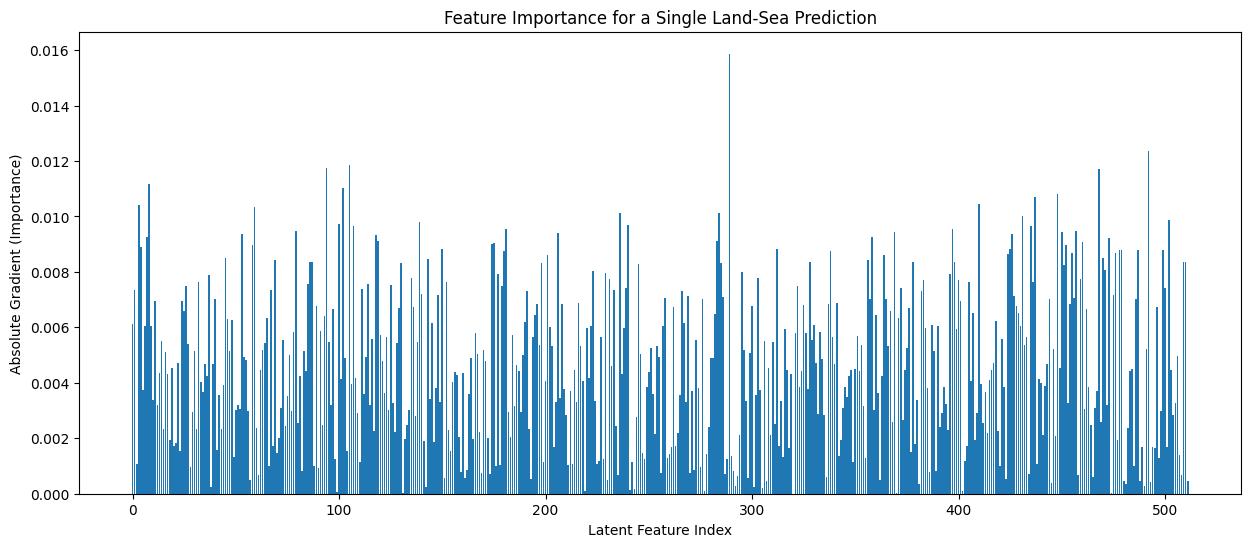

In [27]:
import matplotlib.pyplot as plt

#create bar plot of the absolute gradient values
plt.figure(figsize =(15, 6))
plt.bar(range(len(gradients)), torch.abs(gradients).numpy())
plt.xlabel("Latent Feature Index")
plt.ylabel("Absolute Gradient (Importance)")
plt.title("Feature Importance for a Single Land-Sea Prediction")
plt.show()

## Atmospheric Instability Analysis

In [ ]:
import dask.array as da
from dask_ml.linear_model import LogisticRegression
from dask_ml.preprocessing import StandardScaler
from dask_ml.model_selection import train_test_split

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
atmos_insta_masks = xr.open_zarr("gs://aurora-encoder-storage/atmos_instability_masks.zarr")
atmos_insta_masks = atmos_insta_masks.isel(valid_time=slice(0, 2))
patched_atmos_insta_masks = reduce_mask_lazy(atmos_insta_masks, patch_size=patch_size)

In [ ]:
k_gt_20_mask = patched_atmos_insta_masks["k_gt_20"].data.reshape(-1)
k_gt_35_mask = patched_atmos_insta_masks["k_gt_35"].data.reshape(-1)

In [ ]:
atmos_embeddings = atmos_embeddings.isel(time=slice(0, 2))

level0_atmos = get_optimal_chunks_ds(atmos_embeddings.sel(level=0))
level1_atmos = get_optimal_chunks_ds(atmos_embeddings.sel(level=1))
level2_atmos = get_optimal_chunks_ds(atmos_embeddings.sel(level=2))

X0 = level0_atmos.transpose("time", "lat", "lon", "embed")
X0 = X0.data.reshape(-1, 512)
X1 = level1_atmos.transpose("time", "lat", "lon", "embed")
X1 = X1.data.reshape(-1, 512)
X2 = level2_atmos.transpose("time", "lat", "lon", "embed")
X2 = X2.data.reshape(-1, 512)


In [ ]:
n = atmos_embeddings["time"].size
n_lat_lon = 180 * 360

# When doing the train/test split, we need to keep
# track of the positions so we can trace back errors
# to specific lat/lon locations
indices = da.arange(n_lat_lon * n, chunks=X0.chunks[0])

In [ ]:
X = X0.rechunk(129600, -1)
y = k_gt_20_mask.rechunk(129600, -1)

train_split = 0.8
n = X.shape[0]
n_train = int(n * train_split)
n_test = n - n_train

X_train = X[:n_train]
X_test = X[n_train:]

y_train = y[:n_train]
y_test = y[n_train:]

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X,
#     y,
#     test_size=0.2,
#     random_state=42,
# )

In [ ]:
model = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    max_iter=100,
    random_state=42
)
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
X_train

In [ ]:
X_train.shape, y_train.shape

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
accuracy = da.mean(y_pred == y_test).compute()

print(f"Test accuracy: {accuracy:.4f}")

In [ ]:
is_misclassified = (y_pred != y_test)

In [ ]:
x = X_train.compute()

In [ ]:
x

In [ ]:
X_train